In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import dask.distributed
from backtester_lib.ticker import Ticker
from backtester_lib.utils import open_pricing, generate_random_date_ranges
from backtester_lib.strategies.buy_and_hold import BuyAndHold

from backtester_lib.test_runner import TestRunner

# Initialize Ticker
ticker = Ticker("BTC_1D", "./data//COINBASE_BTCUSD, 1D.csv", "1D")

# Test Strategy Configuration (consolidated keys)
strategy_config = {
    "BuyAndHold": BuyAndHold(),
}

# Pricing function config
pricing_function_config = [
    ("Transaction on Open", open_pricing, open_pricing, open_pricing)
]

# Date ranges
n = 1000
min_range = 2
max_range = None
start_date = datetime(2020, 1, 1)
end_date = ticker.dataframe.index[-1]
ranges = generate_random_date_ranges(start_date, end_date, n, min_range, max_range)


# Test Function
def run_test(d1, d2, strategies, pricing_functions):
    runner = TestRunner(
        ticker,
        start_date=d1,
        end_date=d2,
        strategies=strategies,
        pricing_functions=pricing_functions,
    )
    runner.run_tests()
    return runner.test_results


# Function to run tests on a given date range
def test_unpack(range_dates, strategy_config, pricing_function_config):
    strategies = [(name, strat) for name, strat in strategy_config.items()]
    return run_test(range_dates[0], range_dates[1], strategies, pricing_function_config)


# Distributed execution using Dask
def run_tests_with_dask(ranges, strategy_config, pricing_function_config):
    pool = dask.distributed.Client()
    test_results_futures = pool.map(
        test_unpack,
        ranges,
        strategy_config=strategy_config,
        pricing_function_config=pricing_function_config,
    )
    test_results = pool.gather(test_results_futures)
    return test_results


# Running tests
test_results = run_tests_with_dask(ranges, strategy_config, pricing_function_config)


In [2]:
# Collecting Results (dynamically generate column names from strategy keys)
results_columns = ["start", "end"]  # Always include start and end date
for strategy in strategy_config:
    results_columns.append(f"{strategy.lower()}_end_balance")
    results_columns.append(f"{strategy.lower()}_annualized_roi")

# Collecting results dynamically based on strategy keys
results = [results_columns]  # Initialize with header

for tr in test_results:
    row = [tr[list(tr.keys())[0]].start_date, tr[list(tr.keys())[0]].end_date]  # Add date range
    for strategy in strategy_config:
        row.append(tr[strategy].end_balance)
        row.append(tr[strategy].annualized_return_on_investment)
    results.append(row)

# Convert results into a DataFrame
df = pd.DataFrame(results[1:], columns=results[0])
df['delta'] = df['end'] - df['start']

In [3]:
def plot_roi_histograms(df, strategy_config, start_date, end_date, min_range, max_range, n):
    # Get column names dynamically based on strategy names
    cols = [f"{strategy.lower()}_annualized_roi" for strategy in strategy_config]
    
    # Calculate the global minimum and maximum across all strategies for uniform x-axis limits
    global_min = df[cols].min().quantile(.2)
    global_max = df[cols].max().quantile(.8)
    print(global_min, global_max)
    # Create one extra subplot for the holding periods histogram
    fig, axs = plt.subplots(nrows=len(cols) + 1, ncols=1, figsize=(8, 14))  # +1 for the holding periods histogram
    fig.suptitle("Histograms of ROI Data and Holding Periods", fontsize=16, y=1.1)

    # Add metadata text to the plot (date ranges, holding period, sample size)
    holding_period_stats = (
        f"Holding Periods (days):\n"
        f"Mean: {df['delta'].dt.days.mean():.2f}, "
        f"Min: {df['delta'].dt.days.min()}, "
        f"Max: {df['delta'].dt.days.max()}, "
        f"25th Percentile: {df['delta'].dt.days.quantile(0.25):.2f}, "
        f"Median: {df['delta'].dt.days.median():.2f}, "
        f"75th Percentile: {df['delta'].dt.days.quantile(0.75):.2f}"
    )
    
    metadata_text = (
        f'Dates Sampled from: {start_date.date()} to {end_date.date()}\n'
        f'Minimum Holding Period: {min_range if min_range else "N/A"} days\n'
        f'Maximum Holding Period: {max_range if max_range else "None"} days\n'
        f'Samples: {n}\n'
        f'{holding_period_stats}'
    )
    fig.text(0.5, 1.05, metadata_text, ha='center', va='top', fontsize=10)

    # Plot the histogram for holding periods (timedeltas)
    axs[0].hist(df['delta'].dt.days, bins=100, color="gray")
    axs[0].set_title('Holding Periods (days)')
    axs[0].set_xlabel('Days')
    axs[0].set_ylabel('Frequency')

    # Iterate over each column for ROI histograms
    for i, x in enumerate(cols, start=1):  # Start from 1 as the first subplot is used for holding periods
        axs[i].hist(df[x], bins=25, color="gray")
        axs[i].set_title(x)

        # Set x-axis limits to be the same across all ROI subplots
        axs[i].set_xlim(global_min, global_max)

        # Set x-axis as percentage
        axs[i].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0, symbol="%"))
        axs[i].tick_params(axis='x', labelsize=8)

        # Calculate statistics
        mean_val = df[x].mean()
        skewness = df[x].skew()
        std_dev = df[x].std()
        median_val = df[x].median()
        percentile_25 = df[x].quantile(0.25)
        percentile_75 = df[x].quantile(0.75)
        min_val = df[x].min()
        max_val = df[x].max()

        # Add vertical lines for mean, median, and quartiles
        axs[i].axvline(mean_val, color="blue", linestyle="--", linewidth=1, label="Mean")
        axs[i].axvline(percentile_25, color="goldenrod", linestyle="--", linewidth=1, label="25th Percentile")
        axs[i].axvline(median_val, color="darkorange", linestyle="--", linewidth=1, label="Median")
        axs[i].axvline(percentile_75, color="red", linestyle="--", linewidth=1, label="75th Percentile")

        # Display legend for the vertical lines
        axs[i].legend()

        # Add statistics to the side of each plot
        stats_text = f"Mean: {mean_val:.2f}\nStd Dev: {std_dev:.2f}\nSkewness: {skewness:.2f}\nMin: {min_val:.2f}\n25th Percentile: {percentile_25:.2f}\nMedian: {median_val:.2f}\n75th Percentile: {percentile_75:.2f}\nMax: {max_val:.2f}"
        axs[i].text(
            1.05,
            0.5,
            stats_text,
            transform=axs[i].transAxes,
            fontsize=10,
            va="center",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.5),
        )

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


In [6]:

import copy
# Call the plotting function
results_dict = copy.deepcopy(strategy_config)

-6.797790164325357 10.2756954421365


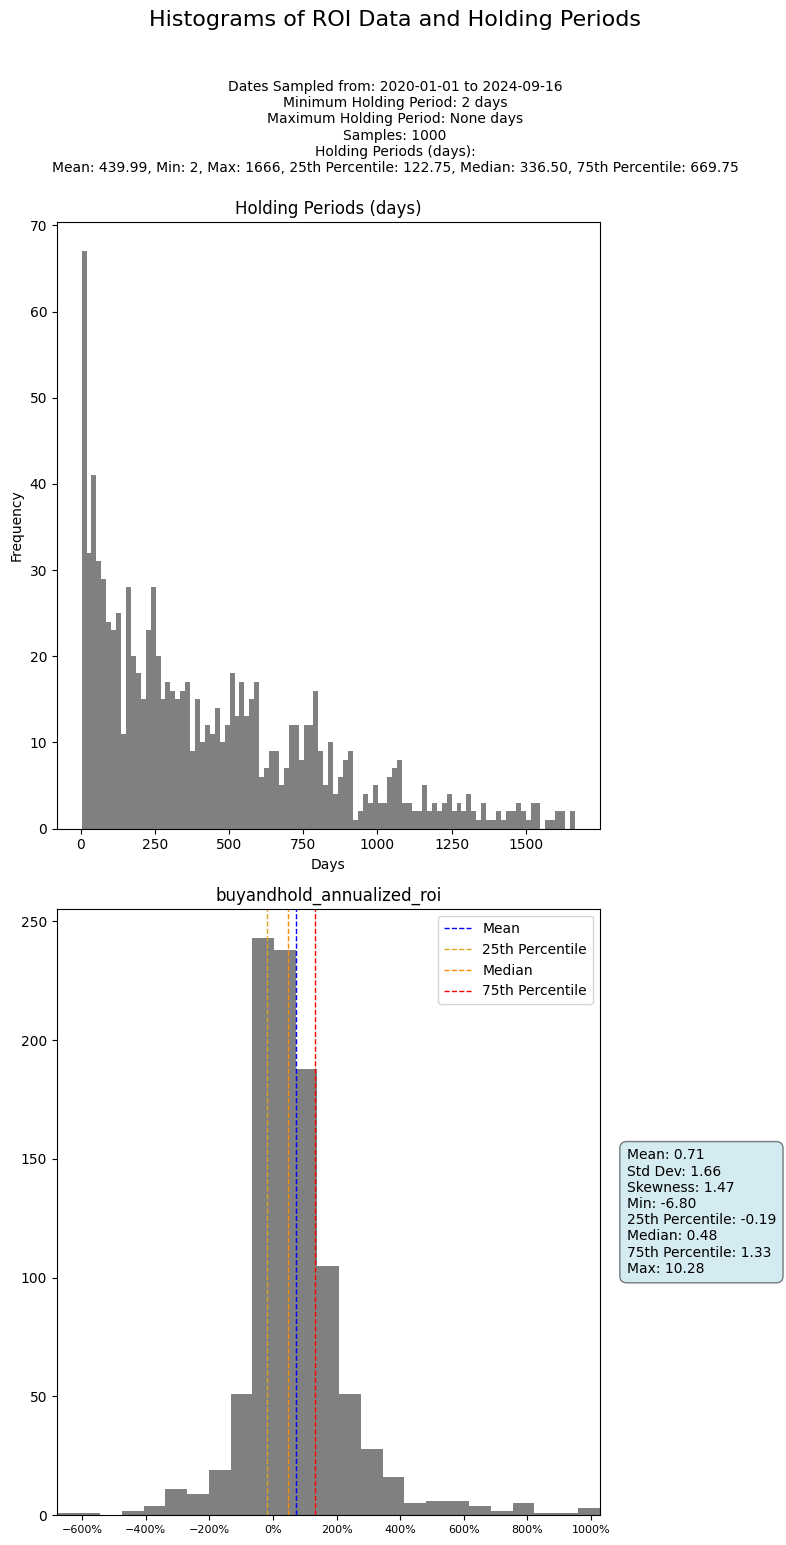

In [7]:

plot_roi_histograms(df, results_dict, start_date, end_date, min_range, max_range, n)